### Introduction/Setup

##### In this notebook, you will be guided through some of the code in this codebase, with the aim of demonstrating how node embedding algorithms can be used to represent networks by learning a vector representation for each node, and how these representations can also be applied downstream to perform machine-learning tasks on networks.

##### It is highly recommended that you use a virtual environment (e.g. Pyenv or Conda) to manage package versions. As of July 2025, this codebase runs using Python 3.11.9. Please refer to the requirements.txt file on the github repo to find all required dependencies.

##### Now that all the required packages are downloaded, let's load the ones that we'll directly use in this notebook, as well as the functions from the code that we'll use:

In [1]:
from DGIImplementation.DGI_train import get_embeddings_dgi
from GraRepImplementation.grarep_train import get_embeddings_grarep
from GraphSageImplementation.graphsage_train import get_embeddings_graphsage
from LINEImplementation.line_train import get_embeddings_line
from logistic_regression import logreg_fit_predict, get_prediction_metrics
from Node2vecImplementation.n2v_train import get_embeddings_node2vec
import numpy as np
import pandas as pd
from plot_embeddings import plot
from sbm_plotter import plot_network
from sbm_simulator import generate_sbm_network
from SpectralClusteringImplementation.spectral_clustering_train import get_embeddings_spectral_clustering
from utils import InvalidNetworkStructure, to_int

### Generating the Network

##### The network we will use will be generated from a Stochastic Block Model (SBM), which is a class of networks where:
##### - Each node belongs to one of K possible node classes
##### - For any 2 classes, a probability is specified, namely, the probability of there being an edge between nodes of those 2 classes. In other words, the probability of an edge between two nodes is dependent only on the classes which the nodes belong to. Go [here](https://appliednetsci.springeropen.com/articles/10.1007/s41109-019-0232-2) if you want to learn more about SBMs.

##### For this example, we have K=3 node classes. We also set the probability of an edge connection between nodes in different classes to be 0.1, and the probability of an edge connection between two nodes both in class 1 (or class 2, or class 3) to be the command line arguments p1, p2, & p3 respectively.

##### For ease of visualization, our network will only have 100 nodes, but performance on downstream tasks may be improved by using more (e.g. 500 or 1000) nodes. 

##### <u>Note:</u> If you want to run the embedding methods on your own graph/network, simply save it in this same network variable below (i.e. don't run generate_network()) and the rest of the code should work just fine. Since our network has 100 nodes, our node embedding vectors will have 32 dimensions (except for Spectral Clustering, see the <i>Obtaining Node Embeddings</i> section below). You can set the embedding dimension you would like to use for your network using the dimensions variable in the code block; it is recommended to use more dimensions if your network has more nodes (e.g. 64 or 128 dimensions if you have 1K to 100K nodes, 256 for >100K nodes, 512 for networks with a very complex structure and >100K-1M nodes). 

##### For Node2vec and LINE, the ideal value for some of the parameters changes based on the size of the network, keep this in mind if you notice poor performance using those methods on your network.

##### <b><u>Note:</u></b> If using your own network, ensure that every node has an attribute named "label", this attribute will be used to determine the true cluster/class each node belongs to. If your network has weighted edges, ensure the weight info is stored in an edge attribute named "weight", otherwise, every edge will be assumed to have a weight of 1.

In [2]:
# p1, p2, and p3 are the within-class edge probabilities for class 1, 2, and 3 respectively

network = generate_sbm_network(num_nodes=100, p1=0.5, p2=0.7, p3=0.9)

dimensions = 32

### Visualizing the Network

##### Now that we have simulated our SBM network, we visualize it below. Each node colour represents a node class, and the darker the edges appear to be, the more edges there are in that region.

##### Above, we specified the within-class edge probabilities to be 0.5, 0.7, & 0.9. In the plot below, you should be able to see this distinction with one of the classes having more edges between its nodes than the others.

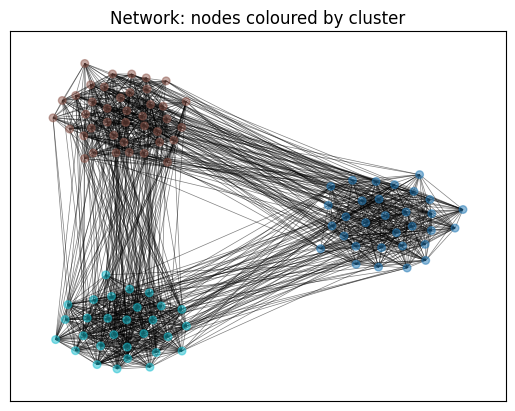

In [3]:
try:
    plot_network(network)
except InvalidNetworkStructure as e:
    # If a node in the network doesn't have an attribute named "label", an exception is raised, 
    # since it is required for determining the node's class
    print(f"Error: {e}")

### Obtaining the Node Embeddings

##### <u>Note:</u> For all the embedding methods, except Spectral Clustering, we will use node embeddings which have 32 dimensions. This is to allow for fair comparisons of results across methods. Also, since we have 100 nodes, 32 is a good number to ensure the methods have enough flexibility in the embedding space to capture meaningful information, without [overfitting](https://en.wikipedia.org/wiki/Overfitting) (which would be more likely with 128 dimensions or more). For Spectral Clustering, since we know the network was generated by an SBM with 3 clear classes, a good choice for the number of dimensions is 3, as 32 dimensions may cause the method to overfit to noise in the data.

#### Spectral Clustering

##### The first method we will use for learning node embeddings is Spectral Clustering. It learns the embeddings using the eigenvectors of the network's laplacian matrix. The laplacian matrix is simply the degree matrix minus the adjacency matrix.

##### More specifically, Spectral Clustering takes the K (K = number of classes) smallest eigenvectors (smallest regarding the size of their associated eigenvalues), excluding the trivial eigenvector. This results in K eigenvectors of length n (n = number of nodes) which are then horizontally concatenated into an n x K matrix. Finally, each row of this matrix is the embedding for the corresponding node.

##### The node embeddings learned by Spectral Clustering capture node proximity (whether two nodes are adjacent), a node's local neighbour structure, and global network structure. If the input network is generated from a SBM, Spectral Clustering, the vast majority of the time, learns embeddings that are very close to each other for nodes part of the same class. See Chapter 2.3 of [this](https://www.cs.mcgill.ca/~wlh/grl_book/files/GRL_Book.pdf) textbook if you want more detail on Spectral Clustering.

##### Parameters:
#####   - dim=3 (fixed)

In [4]:
## Learning node embeddings using Spectral Clustering
spec_embeddings = get_embeddings_spectral_clustering(network, embeddings_filename="spectral_clustering_node_embeddings.csv")
spec_embeddings = pd.DataFrame(spec_embeddings) # for nicer printing

print(f"Number of rows: {spec_embeddings.values.shape[0]}\nNumber of columns: {spec_embeddings.values.shape[1]}")
print(spec_embeddings.iloc[:10, :]) # printing first 10 rows

Number of rows: 100
Number of columns: 3
          0         1         2
0  0.058710 -0.085161  0.084132
1  0.043205 -0.091799 -0.078271
2  0.111079 -0.163150  0.000320
3  0.049060 -0.102517 -0.140835
4  0.063853 -0.069554 -0.017521
5  0.048879 -0.101618  0.034443
6  0.043057 -0.083798  0.075199
7  0.052046 -0.124843 -0.035853
8  0.082892 -0.120171  0.023809
9  0.058297 -0.095276  0.012430


#### Node2Vec

##### The second method we will use is [Node2Vec](https://arxiv.org/pdf/1607.00653), a stochastic (i.e. non-deterministic) method which uses random walks across the network to learn node embeddings. With Node2Vec, two nodes will have similar embeddings if they tend to co-occur on short walks across the network. Node2Vec was inspired by the word2vec model used in natural language processing (NLP).

##### Using the default parameter settings (p=1, q=1), at any node during the random walk, (assuming the graph is unweighted), the probability of moving to an adjacent node is simply a uniform distribution over all adjacent nodes, (i.e. each adjacent node has the same probability). If the graph is weighted, the probability of moving to an adjacent node is proportional to the weight of the edge between the current node and adjacent node.

##### Moreover, we can change the parameters p and q to make the random walk biased (See Section 3.2.2 of the paper in the above hyperlink). Increasing p increases the chance of returning to the node you just previously visited ("taking a step back"), and increasing q increases the chance of visiting nodes that are close to the node that you've just visited. We will be using the default parameter settings of p=1 and q=1.

##### Parameters:
#####   - dim=32 (fixed)
#####   - walk_length: length of each random walk<br> &emsp;- increasing it allows for global network structure to be factored into a node's embedding, whereas decreasing it focuses more on a node's local neighbourhood structure<br> &emsp;- increasing it increases the compute time and memory usage
#####   - num_walks: number of random walks to be done starting from each node<br> &emsp;- increasing it (up to a point, e.g. 10) allows diverse neighbourhood information to be captured<br> &emsp;- increasing it also increases compute time and memory usage
#####   - p: influences the chance of revisiting the node just previously visited in the random walk (see above)
#####   - q: influences the chance of visiting a node close to the node just visited in the random walk (see above)
#####   - window (size): used when training the embeddings, it is the max distance between pairs of nodes along a  walk that can influence each other's embeddings<br> &emsp;- increasing it can allow for global structure to be captured, but at the risk of over-smoothing the embeddings and increasing compute time and memory usage


In [5]:
## Learning node embeddings using Node2vec
n2v_embeddings = get_embeddings_node2vec(network, dimensions=dimensions, walk_length=60, 
                                         num_walks=10, p=1, q=1, window_size=10, 
                                         embeddings_filename="n2v_node_embeddings.csv")
n2v_embeddings = pd.DataFrame(n2v_embeddings)

print(f"\nNumber of rows: {n2v_embeddings.values.shape[0]}\nNumber of columns: {n2v_embeddings.values.shape[1]}")
print(n2v_embeddings.iloc[:10, :6]) # printing first 10 rows and first 6 columns

Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 65.67it/s]



Number of rows: 100
Number of columns: 32
          0         1         2         3         4         5
0 -0.101148 -0.168153  0.101544  0.312943 -0.095388 -0.255403
1 -0.000985 -0.176552  0.145704  0.162410 -0.012304 -0.095276
2 -0.174424 -0.300555  0.042862  0.207092 -0.062326 -0.049648
3 -0.245985 -0.238935  0.112361  0.109438 -0.094094 -0.145360
4 -0.270975 -0.177201  0.194849  0.224462 -0.034096 -0.113463
5  0.312416  0.068044 -0.027078 -0.132778  0.014398 -0.106317
6 -0.150738 -0.306153 -0.055911  0.099341 -0.013470 -0.214288
7 -0.079836 -0.256963  0.216282  0.330561 -0.002085 -0.115895
8 -0.179322 -0.248571  0.151915  0.260661  0.031139 -0.190106
9 -0.166235 -0.221584  0.167875  0.325762  0.107925 -0.188244


#### LINE

##### The next method we will use is [LINE](https://arxiv.org/pdf/1503.03578) (Large-scale information network embeddings). LINE captures both whether nodes are adjacent (first-order proximity) and the similarity of their neighbourhoods/how many neighbours they have in common (second-order proximity), which is useful since in many applications you may want non-adjacent nodes who share many common neighbours to be encoded as being similar.

##### When incorporating first-order proximity, LINE learns to give similar embeddings to adjacent nodes, and different embeddings to non-adjacent ones. When incorportating second-order proximity, LINE essentially learns, for each node, a probability distribution over its neighbour nodes. Using this, LINE gives similar embeddings to nodes who have many neighbours in common, and different embeddings to those who don't.

##### The final embeddings output by LINE are just the concatenation of the first-order proximity and second-order proximity embeddings.

##### Parameters:
#####   - dim=32 (fixed)
#####   - epochs: number of times to iterate over each node when learning the embeddings (since in practice the training process minimizes a logloss function)<br> &emsp;- increasing this can improve the embeddings, but increasing it too much can cause noise in the network to be over-emphasized, potentially worsening results in downstream tasks
#####   - batchsize: number of edges used at once to update the embeddings (for gradient descent)
#####   - lr: learning rate, controls how aggresive the gradient descent process is<br> &emsp;- increasing it makes it more aggresive and potentially converge faster, but at the risk of missing/overshooting the optimum embeddings
#####   - neg: number of negative samples drawn for each pair of adjacent nodes; they are used to help ensure that the embeddings of non-adjacent nodes are different

In [6]:
## Learning node embeddings using LINE
line_embeddings = get_embeddings_line(network, epochs=100, batch_size=256, learning_rate=0.01,
                                 size_of_negative_sample=5, embeddings_filename="line_node_embeddings.csv",
                                 dimensions=int(dimensions/2)) # divide by 2 because LINE's dimensions parameter is
                                                          # the num of dimensions for each order, and we have 
                                                          # order 1 and order 2 (two orders)
line_embeddings = pd.DataFrame(line_embeddings)

print(f"\nNumber of rows: {line_embeddings.values.shape[0]}\nNumber of columns: {line_embeddings.values.shape[1]}")
print(line_embeddings.iloc[:10, :6])

1/2. Building and sorting scaled probabilities for alias table...


100%|██████████| 1353/1353 [00:00<00:00, 973395.08it/s]


2/2. Building alias table...
1/2. Building and sorting scaled probabilities for alias table...


100%|██████████| 99/99 [00:00<00:00, 832136.46it/s]

2/2. Building alias table...
Number of nodes: 100



Training on cpu...


Done training, saving models
Saving loss data at LINEImplementation/loss_data.pkl
Saving embeddings at LINEImplementation/line_node_embeddings.csv

Number of rows: 100
Number of columns: 32
          0         1         2         3         4         5
0 -0.226885  0.309439 -0.027595  0.388561 -0.155973 -0.105758
1  0.401996 -1.155676 -0.242030  0.013364 -0.567528 -0.058956
2  0.184538 -0.146675 -0.181047  0.285594  0.030053  0.111679
3  0.515721 -0.083168 -0.466282 -0.772577  0.192167  0.455888
4  0.009241  0.100773  0.203667  0.154638  0.280252 -0.374028
5 -0.230526 -0.222079  0.632769  0.095354  0.289005  0.755102
6  0.226927 -0.095886  0.440692 -0.017035  0.263947 -0.440754
7  0.225834 -0.403361  0.041327  0.130515  0.023172  0.390779
8  0.000114 -0.075553 -0.232312  0.083439  0.042599  0.520552
9 -0.036060 -0.201334 -0.172459 -0.013927 -0.000483  0.534572


#### GraRep

##### Another method we will use is [GraRep](https://www.researchgate.net/publication/301417811_GraRep), which includes up to the K^th order-proximity in a node's embedding (i.e. info about other nodes within a distance of K, also called the K-hop neighbourhood). Unlike LINE, the use of higher order proximities allows for more global network structure to be encoded, which is useful for large complex networks.

##### GraRep first computes the row-normalized powers of the adjacency matrix, for each power up to K, which represents the probability of moving from one node to another in exactly k steps (k=1,...,K). Next, this matrix is transformed such that node pairs which co-occur (on the same random walk) more often than expected are given larger values in the matrix than pairs which co-occur less often than expected. This is to prevent "hub nodes"/high degree nodes from influencing nodes' embeddings too much. 

##### Finally, this matrix is factored using [Singular Value Decomposition](https://www.youtube.com/watch?v=nbBvuuNVfco&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv&index=2) (SVD) which essentially does dimensionality reduction on the previous matrix, thus filtering out noise and providing a meaningful lower dimensional representation for each node.

##### The lower dimensional representations for each k are concatenated together to obtain the final node embeddings.

##### Parameters:
#####   - dim=30 (6*5) (fixed), can't use 32 since it isn't a multiple of order=6
#####   - order: highest power of the (normalized) adjacency matrix to use


In [7]:
## Learning node embeddings using GraRep
grarep_embeddings = get_embeddings_grarep(network, order=6, dimensions=dimensions//6, # repesents dimension per order, rounding down to nearest int
                                          embeddings_filename="grarep_node_embeddings.csv")
grarep_embeddings = pd.DataFrame(grarep_embeddings)

print(f"\nNumber of rows: {grarep_embeddings.values.shape[0]}\nNumber of columns: {grarep_embeddings.values.shape[1]}")
print(grarep_embeddings.iloc[:10, :6])

100%|██████████| 6/6 [00:01<00:00,  3.91it/s]


Number of rows: 100
Number of columns: 30
          0         1         2         3         4         5
0 -1.236713  0.017160  0.041597 -0.002985 -0.046686 -1.236850
1 -1.236708  0.010712  0.039569 -0.013555 -0.031622 -1.236658
2 -1.236663  0.024467  0.053809 -0.074688  0.026929 -1.236142
3 -1.236731  0.011303  0.042004 -0.011783 -0.044342 -1.236475
4 -1.236594  0.018809  0.031178 -0.004440  0.030066 -1.236590
5 -1.236703  0.011526  0.042710  0.019223 -0.013760 -1.236527
6 -1.236687  0.010871  0.036786  0.032060  0.011435 -1.236729
7 -1.236763  0.010610  0.053787  0.036555 -0.001799 -1.236681
8 -1.236739  0.023626  0.054844  0.012691 -0.000267 -1.236664
9 -1.236678  0.014311  0.037692 -0.033779  0.001510 -1.236330


#### GraphSage

##### [GraphSage](https://arxiv.org/pdf/1706.02216) is the first of two methods we will consider that are based on the Graph Neural Network (GNN) framework. In short, GNNs learn node embeddings by iteratively aggregating the embeddings from neighbouring nodes and updating a node's embedding using this aggregated info. Doing many iterations of this allows each node to contain info from both its local neighbourhood and the global network structure, (the embeddings at the first iteration are just node features or node statistics / learnable parameters if there are no node features). If you would like to learn more about GNNs, reference chapters 5 and 6 in [this](https://www.cs.mcgill.ca/~wlh/grl_book/files/GRL_Book.pdf) same textbook.

##### The authors of the GraphSage paper present 3 options for defining the aggregator function, and in this implementation we use their "mean aggregator" option, which actually combines the aggregation and updating by taking the element-wise mean over all of a node's neighbours, including the node itself, and passing the result through a fully connected neural net (with no hidden layers) and the ReLU activation function. This choice for the aggregator (and updater) results in an architecture very similar to the one used in Deep Graph Infomax (see below). The standard choice for the loss function used to optimize these parameters is the negative log-likelihood with negative sampling (the same loss fn as node2vec), but a different task-appropriate loss fn can be used if the embeddings are to be used on specific downstream tasks.

##### Our implementation utilizes mini-batch sampling to keep the memory footprint low. This means that, for each iteration, the embeddings are computed and updated for only the nodes which will be sampled as neighbours in later iterations (since their embeddings will be part of the aggregation step then).

##### One last point is that we don't actually consider all of a node's neighbours in the aggregation step; just a fixed-size uniformly-drawn sample over the neighbours. This ensures the time and space complexity remain low.

##### Parameters:
#####   - dim=32 (fixed)
#####   - epochs: number of times to iterate over each node, during gradient descent, when learning the embeddings (note: the "iterating" mentioned here is unrelated to the "iterating" mentioned above)<br> &emsp;- there's essentially a linear relationship between the num. of epochs and the run time, so be careful when increasing it<br> &emsp;- this implementation uses [early stopping](https://milvus.io/ai-quick-reference/what-is-early-stopping), which means the number of epochs conducted may be fewer
#####   - K: number of iterations to run the aggregate and update procedures per node (this refers to the same iterating mentioned in the above paragraphs); the paper says choosing K>2 provides small accuracy improvements but drastically larger run times
#####   - neigh_sizes: number of neighbours to sample for each iteration k, 1 <= k <= K
#####   - num_learnable_features: dimension to use for the (learnable) node feature vector if there isn't a node feature vector for each node in the network
#####   - all the parameters in node2vec (except p and q), since, like node2vec, the loss function uses "positive pairs" of nodes that are generated from random walks
#####   - Q: number of negative samples per positive pair of nodes

In [8]:
## Learning node embeddings using GraphSage
graphsage_embeddings = get_embeddings_graphsage(network, num_epochs=10, K=2, neigh_sizes=[10, 5], 
                                                embed_dim=dimensions, lr=0.001, num_walks=10, 
                                                walk_length=80, window_size=5, neg_sample_size=5,
                                                patience=2,
                                                embeddings_filename="graphsage_node_embeddings.csv")
graphsage_embeddings = pd.DataFrame(graphsage_embeddings)

print(f"\nNumber of rows: {graphsage_embeddings.values.shape[0]}\nNumber of columns: {graphsage_embeddings.values.shape[1]}")
print(graphsage_embeddings.iloc[:10, :6])

1/2. Building and sorting scaled probabilities for alias table...


100%|██████████| 99/99 [00:00<00:00, 593194.42it/s]


2/2. Building alias table...

Training on cpu...

Epoch 0


100%|██████████| 1/1 [00:11<00:00, 11.51s/it]


Validation Loss: 8009724416.0000
Epoch 1


100%|██████████| 1/1 [00:11<00:00, 11.35s/it]


Validation Loss: 7561022464.0000
Epoch 2


100%|██████████| 1/1 [00:12<00:00, 12.51s/it]


Validation Loss: 7585493504.0000
EarlyStopping counter: 1 out of 2
Epoch 3


100%|██████████| 1/1 [00:11<00:00, 11.64s/it]


Validation Loss: 7919882752.0000
EarlyStopping counter: 2 out of 2
Early stopping triggered

Done training, saving model at GraphSageImplementation/GraphSageImplementation/GraphSage_model.pt
Saving embeddings at GraphSageImplementation/graphsage_node_embeddings.csv

Number of rows: 100
Number of columns: 32
     0    1         2         3    4         5
0  0.0  0.0  0.082085  0.090097  0.0  0.240883
1  0.0  0.0  0.082085  0.090097  0.0  0.240883
2  0.0  0.0  0.082085  0.090097  0.0  0.240883
3  0.0  0.0  0.082085  0.090097  0.0  0.240883
4  0.0  0.0  0.082085  0.090097  0.0  0.240883
5  0.0  0.0  0.082085  0.090097  0.0  0.240883
6  0.0  0.0  0.082085  0.090097  0.0  0.240883
7  0.0  0.0  0.082085  0.090097  0.0  0.240883
8  0.0  0.0  0.082085  0.090097  0.0  0.240883
9  0.0  0.0  0.082085  0.090097  0.0  0.240883


#### DeepGraphInfomax

##### [Deep Graph Infomax (DGI)](https://arxiv.org/pdf/1809.10341), being a GNN, also iteratively aggregates and updates node embeddings based on its neighbours (i.e. it follows the message passing framework as all GNNs do, see chapter 5.1.1 of [this](https://www.cs.mcgill.ca/~wlh/grl_book/files/GRL_Book.pdf) textbook for an intro to this). Its main difference with GraphSage is that its loss function aims to maximize the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) between node embeddings and a "network summary vector" (rather than trying to generate similar embeddings for nodes which co-occur on random walks, which is what GraphSage's loss funtion does). DGI does this using a [noise-contrastive approach](https://medium.com/@weidagang/demystifying-noise-contrastive-estimation-nce-in-machine-learning-32ded05401f4) where the "positive samples" are the learned node embeddings from the real network, and the "negative samples" are node embeddings learned from a corrupted version of the network, which is obtained by randomly shuffling the rows of the feature matrix X. This shuffling influences the embedding at deeper layers/iterations, since the initial layer 0 embeddings are these feature values themselves. The 3 main components of DGI are the encoder, the readout function, and the discriminator function.

##### DGI's encoder is a [Graph Convolutional Network (GCN)](https://towardsdatascience.com/graph-convolutional-networks-introduction-to-gnns-24b3f60d6c95/), which is a neural network that, at each layer, aggregates information from all of a node's neighbours (and the node itself, usually). The neighbours get normalized based on their degree (higher degree neighbours have less influence). This is done so that hub-nodes, which are adjacent to many of the network's nodes, don't over-influence those nodes' learned embeddings, and indirectly the embeddings of all nodes (through subsequent aggregations). The only difference between this encoder and GraphSage's mean aggregator is that: a. this encoder doesn't sample neighbours; b. this encoder scales a neighbour's influence based on its degree.

##### The role of the readout function is to produce the "network summary vector", given the embedding vectors for all the nodes. It is simply the sigmoid function applied to the mean vector of all the embedding vectors, where this mean vector is the element-wise mean of all the embedding vectors.

##### The discriminator function (D) is used to distinguish embeddings from the real network (positive samples) and embeddings from the corrupted network (negative samples). It takes in an embedding vector and the network summary vector, and outputs the probability that the embedding vector comes from the real network. The loss function is trained so that D outputs values close to 1 for positive samples and 0 for negative samples. As a result, the embeddings from the real network are tuned/updated (through backpropogation) to contain information consistent with the network summary vector, and thus, consistent with the network's overall structure.

##### The loss function, employing a noise-contrastive approach, uses the [binary cross-entropy (BCE) loss](https://www.youtube.com/watch?v=DPSXVJF5jIs) between: the probabilites from D for the real network embeddings and the probabilites from D for the corrupted network embeddings. Optimizing this loss function is equivalent to maximizing the mutual information between the real network embeddings and the network summary vector (based on the Jensen-Shannon divergence, whose details are beyond the scope of this tutorial).

##### DGI's noise contrasitive approach allows it to learn node embeddings that contain info about its features, its local neighbourhood, and its role in the network globally in an unsupervised fashion, which is useful when dealing with types of networks where there may not be many labelled networks/nodes.

##### If the nodes in a network don't have any feature information, the node's degree and its one-hot id vector are used as a replacement. This still allows for good performance, as DGI acheived 100% test accuracy on the SBM generated earlier in this notebook (which doesn't have feature information).

##### Parameters:

##### - dim=32 (fixed)
##### - num_epochs: number of times to iterate over each node during gradient descent, note that this iteration is different from the iteration mentioned above that is used during forward propogation<br> &emsp;- this implementation also uses [early stopping](https://milvus.io/ai-quick-reference/what-is-early-stopping), which means the number of epochs conducted may be fewer
##### - patience: the maximum number of consecutive epochs for which the loss is aloud to worsen before early stopping is engaged
##### - K: number of layers in the GCN encoder
##### - lr: learning rate
##### - weight_decay: an L2 pentalty term preventing learned weights from becoming too large (which causes overfitting)<br> &emsp;- larger values give a larger penalty term

In [ ]:
## Learning node embeddings using DeepGraphInfomax
dgi_embeddings = get_embeddings_dgi(network, num_epochs=1000, K=2, embed_dim=dimensions, 
                                          lr=0.001, weight_decay=0.0001, patience=75,
                                          embeddings_filename="graphsage_node_embeddings.csv")
dgi_embeddings = pd.DataFrame(dgi_embeddings)

print(f"\nNumber of rows: {dgi_embeddings.values.shape[0]}\nNumber of columns: {dgi_embeddings.values.shape[1]}")
print(dgi_embeddings.iloc[:10, :6])

NameError: name 'get_embeddings_dgi' is not defined

### Fitting the Logistic Regression Model

##### Now that we have used different methods to generate node embeddings, we can evaluate them by comparing their ability to recover a node's true class given only these embeddings. We will use a [multiclass logistic regression](https://www.youtube.com/watch?v=hYBwBmojXoU&t=676s) model (like regular logistic regression but for more than 2 classes) to predict a node's class and we will do a [train/test split](https://builtin.com/data-science/train-test-split) to ensure the model doesn't overfit to the data it trains on, but instead captures the general signal/pattern between a node's embedding vector and its class.

In [10]:
# Extracting the class label for each node and coverting the labels to ints (enumerating them)
# if they are strings

node_labels = np.array([node_label for node, node_label in network.nodes.data("label")])
if node_labels.dtype.kind != "i":
    node_labels = to_int(node_labels)

#### Spectral Clustering

In [11]:
# Fitting the logistic regression model using the embeddings learned by Spectral Clustering, and
# predicting the class labels for the nodes in the test set

spec_y_predict, spec_y_actual = logreg_fit_predict(spec_embeddings, node_labels, 
                                    "SpectralClusteringImplementation/spectral_clustering_model.pkl")

#### Node2Vec

In [12]:
# Fitting the logistic regression model using the embeddings learned by Node2vec, and
# predicting the class labels for the nodes in the test set

n2v_y_predict, n2v_y_actual = logreg_fit_predict(n2v_embeddings, node_labels,
                                                 "Node2vecImplementation/n2v_model.pkl")

#### LINE

In [13]:
# Fitting the logistic regression model using the embeddings learned by LINE, and
# predicting the class labels for the nodes in the test set

line_y_predict, line_y_actual = logreg_fit_predict(line_embeddings, node_labels, 
                                                   "LINEImplementation/line_model.pkl")

#### GraRep

In [14]:
# Fitting the logistic regression model using the embeddings learned by GraRep, and
# predicting the class labels for the nodes in the test set
    
grarep_y_predict, grarep_y_actual = logreg_fit_predict(grarep_embeddings, node_labels, 
                                                       "GraRepImplementation/grarep_model.pkl")

#### GraphSage

In [15]:
# Fitting the logistic regression model using the embeddings learned by GraphSage, and
# predicting the class labels for the nodes in the test set

graphsage_y_predict, graphsage_y_actual = logreg_fit_predict(graphsage_embeddings, node_labels,
                                                              "GraphSageImplementation/graphsage_model.pkl")

#### DeepGraphInfomax

In [16]:
# Fitting the logistic regression model using the embeddings learned by DeepGraphInfomax, and
# predicting the class labels for the nodes in the test set

dgi_y_predict, dgi_y_actual = logreg_fit_predict(dgi_embeddings, node_labels,
                                                              "DGIImplementation/dgi_model.pkl")

### Assessing the Performance

##### For each embedding method, we will compare each node's predicted class, from the multiclass logistic regression model, with its actual class. There are several ways to compare them, but here are the metrics we will use:
#####   - accuracy: the proportion of nodes where the predicted class equals the actual class
#####   - (macro) precision: the (average over all classes) of the proportion of nodes predicted as a certain class which are actually of that class
#####   - (macro) recall: the (average over all classes) of the proportion of nodes in a certain class which were correctly predicted as being in that class
#####   - (macro) f1-score: the (average over all classes) of the f1-score (see below defn) of each class
#####   - f1-score: the harmonic mean of the (regular) recall and (regular) precision; the harmonic mean is a type of mean/average which prefers lower values, in essence giving lower outputs when one of the terms (precision or recall) is significantly smaller than the other

#### Spectral Clustering

In [17]:
get_prediction_metrics(spec_y_predict, spec_y_actual)

Accuracy: 1.00
(Macro) F1-Score: 1.00
(Macro) Precision: 1.00
(Macro) Recall: 1.00


#### Node2Vec

In [18]:
get_prediction_metrics(n2v_y_predict, n2v_y_actual)

Accuracy: 0.35
(Macro) F1-Score: 0.29
(Macro) Precision: 0.28
(Macro) Recall: 0.30


#### LINE

In [19]:
get_prediction_metrics(line_y_predict, line_y_actual)

Accuracy: 0.95
(Macro) F1-Score: 0.95
(Macro) Precision: 0.97
(Macro) Recall: 0.93


#### GraRep

In [20]:
get_prediction_metrics(grarep_y_predict, grarep_y_actual)

Accuracy: 1.00
(Macro) F1-Score: 1.00
(Macro) Precision: 1.00
(Macro) Recall: 1.00


#### GraphSage

In [21]:
get_prediction_metrics(graphsage_y_predict, graphsage_y_actual)

Accuracy: 0.75
(Macro) F1-Score: 0.72
(Macro) Precision: 0.74
(Macro) Recall: 0.71


#### DeepGraphInfomax

In [22]:
get_prediction_metrics(dgi_y_predict, dgi_y_actual)

Accuracy: 1.00
(Macro) F1-Score: 1.00
(Macro) Precision: 1.00
(Macro) Recall: 1.00


##### It's interesting to note how poorly GraphSage performs given its complexity. A possible reason is that 

### Plotting Node Embeddings

##### As a final touch, let's plot the node embeddings. We'll plot the test node embeddings and colour them by their actual class. Additionally, we'll shade the background grid according to the predicted class for each point, allowing us to see if the test embeddings were correctly predicted. This also allows us to see whether it has (hopefully not) overfit to the training embeddings. Also, since the embeddings have more than 2 dimensions, we will use [PCA](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) to reduce them to 2D.

##### When predicting the class for the grid, we will (for the sake of visualization) use a 2-dimensional logistic regression model which will be trained on the 2D versions of the embeddings. Although this loses some information, it allows the decision boundaries on the 2D plot to be reasonable, interpretable, and to look clean. 

##### <u>Optional:</u> Another alternative for predicting the class for the grid is to project it to the higher dimensional space using the inverse PCA transform (which isn't super reliable, since we have to "make up" new info), but this could cause the decision boundaries to look weird and non-linear. If you would like to generate these plots, run *_plot_embeddings_fulldim.py instead, replacing * with the appropriate embedding method.

#### Spectral Clustering

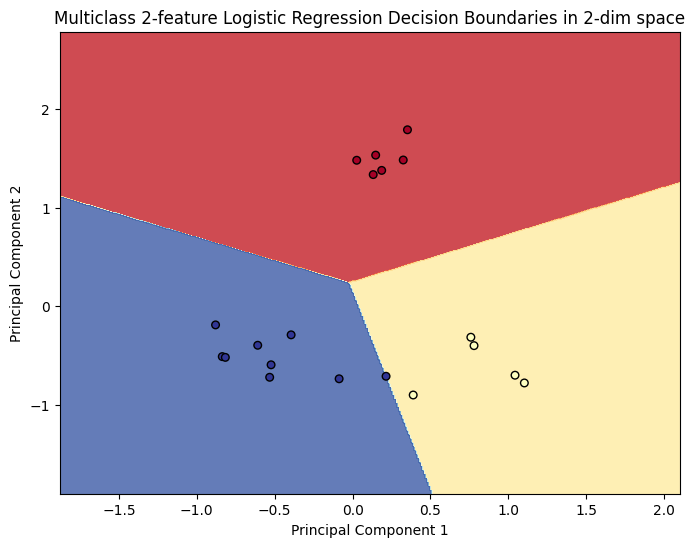

<Figure size 640x480 with 0 Axes>

In [23]:
plot("SpectralClusteringImplementation/spectral_clustering_model.pkl", 
     "SpectralClusteringImplementation/logreg_embeddings.png")

#### Node2Vec

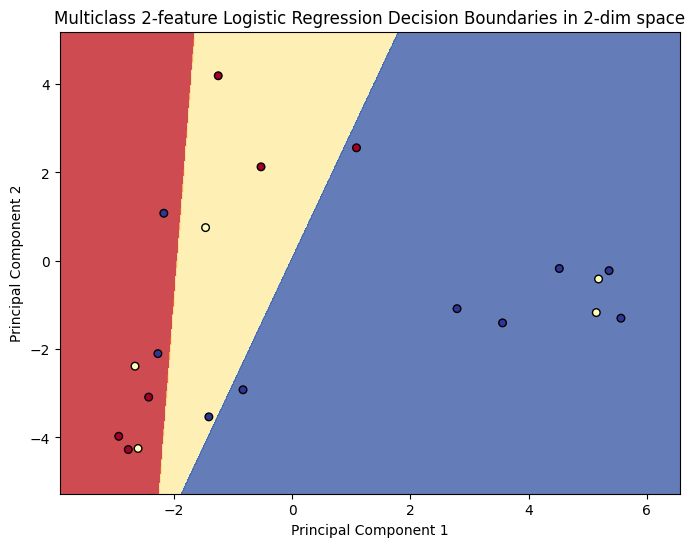

<Figure size 640x480 with 0 Axes>

In [24]:
plot("Node2vecImplementation/n2v_model.pkl", 
     "Node2vecImplementation/logreg_embeddings.png")

#### LINE

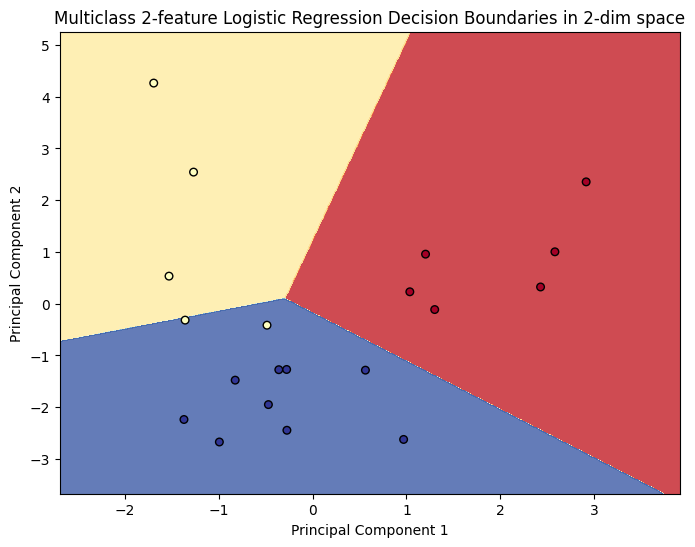

<Figure size 640x480 with 0 Axes>

In [25]:
plot("LINEImplementation/line_model.pkl", 
     "LINEImplementation/logreg_embeddings.png")

#### GraRep

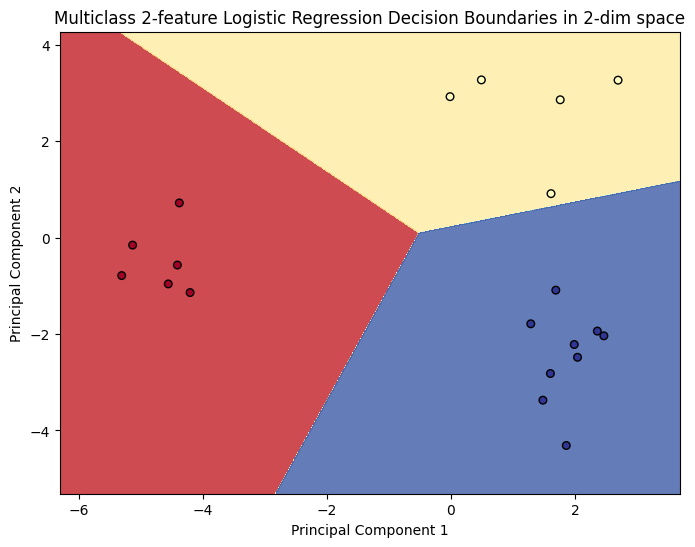

<Figure size 640x480 with 0 Axes>

In [26]:
plot("GraRepImplementation/grarep_model.pkl", 
     "GraRepImplementation/logreg_embeddings.png")

#### GraphSage

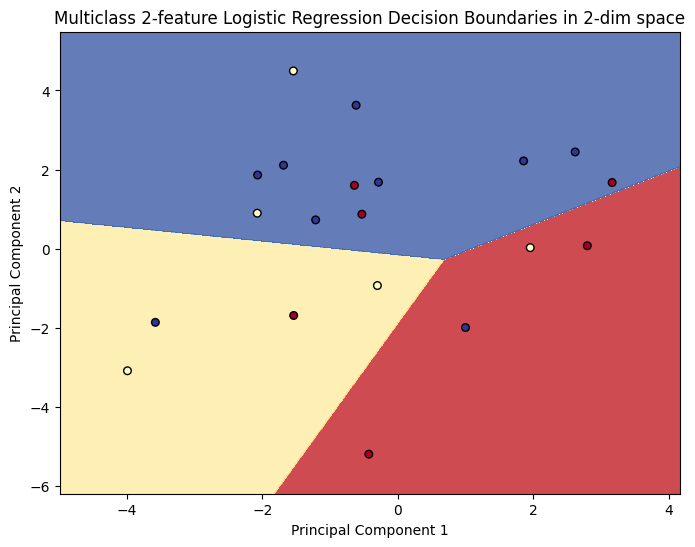

<Figure size 640x480 with 0 Axes>

In [27]:
plot("GraphSageImplementation/graphsage_model.pkl",
     "GraphSageImplementation/logreg_embeddings.png")

#### DeepGraphInfomax

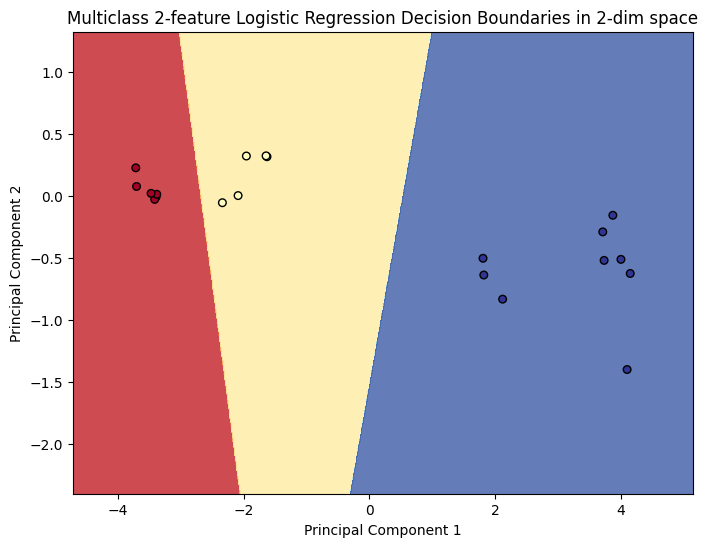

<Figure size 640x480 with 0 Axes>

In [28]:
plot("DGIImplementation/dgi_model.pkl",
     "DGIImplementation/logreg_embeddings.png")

In [29]:
import pickle

with open("GraphSageImplementation/graphsage_model.pkl", "rb") as logreg:
    logreg = pickle.load(logreg)

    model = logreg["Logreg model"]
    X_train = logreg["Training embeddings"]
    y_train = logreg["Actual labels (training)"]

    get_prediction_metrics(model.predict(X_train), y_train)

Accuracy: 0.95
(Macro) F1-Score: 0.95
(Macro) Precision: 0.95
(Macro) Recall: 0.95
